# Brain Tumour Detection Using MRI Scans

### Data Preprocessing

In [1]:
from keras.preprocessing.image import ImageDataGenerator
import cv2
import imutils
import matplotlib.pyplot as plt
from os import listdir

In [2]:
def augment_data(file_dir, n_generated_samples, save_to_dir):
    data_gen = ImageDataGenerator(rotation_range=10, 
                                  width_shift_range=0.1, 
                                  height_shift_range=0.1, 
                                  shear_range=0.1, 
                                  brightness_range=(0.3, 1.0),
                                  horizontal_flip=True, 
                                  vertical_flip=True, 
                                  fill_mode='nearest'
                                 )

    
    for filename in listdir(file_dir):
        # load the image
        image = cv2.imread(file_dir + '\\' + filename)
        # reshape the image
        image = image.reshape((1,)+image.shape)
        # prefix of the names for the generated sampels.
        save_prefix = 'aug_' + filename[:-4]
        # generate 'n_generated_samples' sample images
        i=0
        for batch in data_gen.flow(x=image, batch_size=1, save_to_dir=save_to_dir, 
                                           save_prefix=save_prefix, save_format='jpg'):
            i += 1
            if i > n_generated_samples:
                break

In [5]:
augmented_data_path = 'augmented data/'
# augment data for the examples with label equal to 'yes' representing tumurous examples
augment_data(file_dir='brain_tumor_dataset/yes', n_generated_samples=6, save_to_dir=augmented_data_path+'yes')
# augment data for the examples with label equal to 'no' representing non-tumurous examples
augment_data(file_dir='brain_tumor_dataset/no', n_generated_samples=9, save_to_dir=augmented_data_path+'no')

In [6]:
def data_summary(main_path):
    
    yes_path = main_path+'yes'
    no_path = main_path+'no'
        
    # number of files (images) that are in the the folder named 'yes' that represent tumorous (positive) examples
    m_pos = len(listdir(yes_path))
    # number of files (images) that are in the the folder named 'no' that represent non-tumorous (negative) examples
    m_neg = len(listdir(no_path))
    # number of all examples
    m = (m_pos+m_neg)
    
    pos_prec = (m_pos* 100.0)/ m
    neg_prec = (m_neg* 100.0)/ m
    
    print(f"Number of examples: {m}")
    print(f"Percentage of positive examples: {pos_prec}%, number of pos examples: {m_pos}") 
    print(f"Percentage of negative examples: {neg_prec}%, number of neg examples: {m_neg}")

In [7]:
data_summary(augmented_data_path)

Number of examples: 2061
Percentage of positive examples: 52.54730713245997%, number of pos examples: 1083
Percentage of negative examples: 47.45269286754003%, number of neg examples: 978


### Data Preprocessing

In [8]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, Input, ZeroPadding2D, BatchNormalization, Activation, MaxPooling2D, Flatten, Dense
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.utils import shuffle
import cv2
import imutils
import numpy as np
import matplotlib.pyplot as plt
import time
from os import listdir

In [9]:
def crop_brain_contour(image, plot=False): 
    # Convert the image to grayscale, and blur it slightly
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray = cv2.GaussianBlur(gray, (5, 5), 0)

    # Threshold the image, then perform a series of erosions +
    # dilations to remove any small regions of noise
    thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
    thresh = cv2.erode(thresh, None, iterations=2)
    thresh = cv2.dilate(thresh, None, iterations=2)

    # Find contours in thresholded image, then grab the largest one
    cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    c = max(cnts, key=cv2.contourArea)
    

    # Find the extreme points
    extLeft = tuple(c[c[:, :, 0].argmin()][0])
    extRight = tuple(c[c[:, :, 0].argmax()][0])
    extTop = tuple(c[c[:, :, 1].argmin()][0])
    extBot = tuple(c[c[:, :, 1].argmax()][0])
    
    # crop new image out of the original image using the four extreme points (left, right, top, bottom)
    new_image = image[extTop[1]:extBot[1], extLeft[0]:extRight[0]]            

    if plot:
        plt.figure()

        plt.subplot(1, 2, 1)
        plt.imshow(image)
        
        plt.tick_params(axis='both', which='both', 
                        top=False, bottom=False, left=False, right=False,
                        labelbottom=False, labeltop=False, labelleft=False, labelright=False)
        
        plt.title('Original Image')
                    
        plt.subplot(1, 2, 2)
        plt.imshow(new_image)

        plt.tick_params(axis='both', which='both', 
                        top=False, bottom=False, left=False, right=False,
                        labelbottom=False, labeltop=False, labelleft=False, labelright=False)

        plt.title('Cropped Image')
        
        plt.show()
    
    return new_image

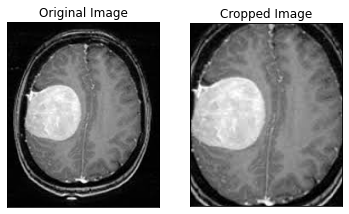

In [10]:
ex_img = cv2.imread('brain_tumor_dataset/yes/Y1.jpg')
ex_new_img = crop_brain_contour(ex_img, True)

In [11]:
def load_data(dir_list, image_size):
    # load all images in a directory
    X = []
    y = []
    image_width, image_height = image_size
    
    for directory in dir_list:
        for filename in listdir(directory):
            # load the image
            image = cv2.imread(directory + '\\' + filename)
            # crop the brain and ignore the unnecessary rest part of the image
            image = crop_brain_contour(image, plot=False)
            # resize image
            image = cv2.resize(image, dsize=(image_width, image_height), interpolation=cv2.INTER_CUBIC)
            # normalize values
            image = image / 255.
            # convert image to numpy array and append it to X
            X.append(image)
            # append a value of 1 to the target array if the image
            # is in the folder named 'yes', otherwise append 0.
            if directory[-3:] == 'yes':
                y.append([1])
            else:
                y.append([0])
                
    X = np.array(X)
    y = np.array(y)
        
    # Shuffle the data
    X, y = shuffle(X, y)
    
    print(f'Number of examples is: {len(X)}')
    print(f'X shape is: {X.shape}')
    print(f'y shape is: {y.shape}')
    
    return X, y

In [12]:
augmented_path = 'augmented data/'

# augmented data (yes and no) contains both the original and the new generated examples
augmented_yes = augmented_path + 'yes' 
augmented_no = augmented_path + 'no'

IMG_WIDTH, IMG_HEIGHT = (240, 240)

X, y = load_data([augmented_yes, augmented_no], (IMG_WIDTH, IMG_HEIGHT))

Number of examples is: 2061
X shape is: (2061, 240, 240, 3)
y shape is: (2061, 1)


In [13]:
def plot_sample_images(X, y, n=50):
    for label in [0,1]:
        # grab the first n images with the corresponding y values equal to label
        images = X[np.argwhere(y == label)]
        n_images = images[:n]
        
        columns_n = 10
        rows_n = int(n/ columns_n)

        plt.figure(figsize=(20, 10))
        
        i = 1 # current plot        
        for image in n_images:
            plt.subplot(rows_n, columns_n, i)
            plt.imshow(image[0])
            
            # remove ticks
            plt.tick_params(axis='both', which='both', 
                            top=False, bottom=False, left=False, right=False,
                           labelbottom=False, labeltop=False, labelleft=False, labelright=False)
            
            i += 1
            label_to_str = lambda label: "Yes" if label == 1 else "No"
        plt.suptitle(f"Brain Tumor: {label_to_str(label)}")
        plt.show()

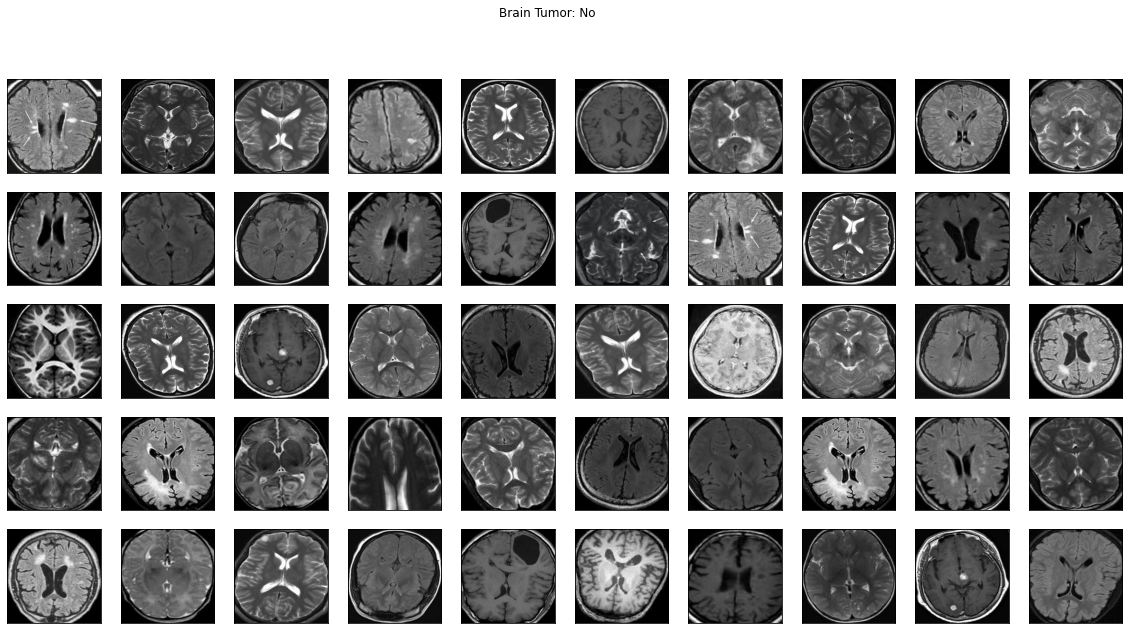

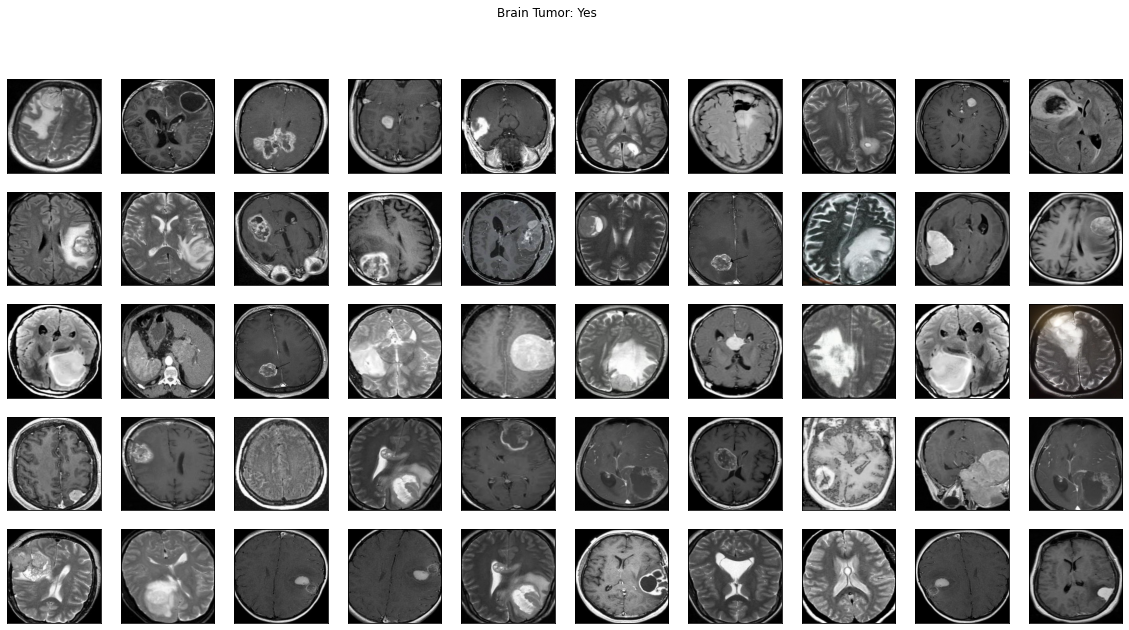

In [14]:
plot_sample_images(X, y)

### Splitting the data

In [15]:
def split_data(X, y, test_size=0.2):
    X_train, X_test_val, y_train, y_test_val = train_test_split(X, y, test_size=test_size)
    X_test, X_val, y_test, y_val = train_test_split(X_test_val, y_test_val, test_size=0.5)
    
    return X_train, y_train, X_val, y_val, X_test, y_test

In [16]:
X_train, y_train, X_val, y_val, X_test, y_test = split_data(X, y, test_size=0.3)

In [17]:
print ("number of training examples = " + str(X_train.shape[0]))
print ("number of development examples = " + str(X_val.shape[0]))
print ("number of test examples = " + str(X_test.shape[0]))
print ("X_train shape: " + str(X_train.shape))
print ("Y_train shape: " + str(y_train.shape))
print ("X_val (dev) shape: " + str(X_val.shape))
print ("Y_val (dev) shape: " + str(y_val.shape))
print ("X_test shape: " + str(X_test.shape))
print ("Y_test shape: " + str(y_test.shape))

number of training examples = 1442
number of development examples = 310
number of test examples = 309
X_train shape: (1442, 240, 240, 3)
Y_train shape: (1442, 1)
X_val (dev) shape: (310, 240, 240, 3)
Y_val (dev) shape: (310, 1)
X_test shape: (309, 240, 240, 3)
Y_test shape: (309, 1)


### Building Model

In [18]:
def build_model(input_shape):
     # Define the input placeholder as a tensor with shape input_shape. 
    X_input = Input(input_shape) # shape=(?, 240, 240, 3)
    
    # Zero-Padding: pads the border of X_input with zeroes
    X = ZeroPadding2D((2, 2))(X_input) # shape=(?, 244, 244, 3)
    
    # CONV -> BN -> RELU Block applied to X
    X = Conv2D(32, (7, 7), strides = (1, 1), name = 'conv0')(X)
    X = BatchNormalization(axis = 3, name = 'bn0')(X)
    X = Activation('relu')(X) # shape=(?, 238, 238, 32)
    
    # MAXPOOL
    X = MaxPooling2D((4, 4), name='max_pool0')(X) # shape=(?, 59, 59, 32) 
    # MAXPOOL
    X = MaxPooling2D((4, 4), name='max_pool1')(X) # shape=(?, 14, 14, 32)
    
    # FLATTEN X 
    X = Flatten()(X) # shape=(?, 6272)
    # FULLYCONNECTED
    X = Dense(1, activation='sigmoid', name='fc')(X) # shape=(?, 1)
    
    # Create model. This creates your Keras model instance, you'll use this instance to train/test the model.
    model = Model(inputs = X_input, outputs = X, name='BrainDetectionModel')
    
    return model

In [19]:
IMG_SHAPE = (IMG_WIDTH, IMG_HEIGHT, 3)

In [20]:
model = build_model(IMG_SHAPE)

In [21]:
model.summary()

Model: "BrainDetectionModel"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 240, 240, 3)]     0         
_________________________________________________________________
zero_padding2d (ZeroPadding2 (None, 244, 244, 3)       0         
_________________________________________________________________
conv0 (Conv2D)               (None, 238, 238, 32)      4736      
_________________________________________________________________
bn0 (BatchNormalization)     (None, 238, 238, 32)      128       
_________________________________________________________________
activation (Activation)      (None, 238, 238, 32)      0         
_________________________________________________________________
max_pool0 (MaxPooling2D)     (None, 59, 59, 32)        0         
_________________________________________________________________
max_pool1 (MaxPooling2D)     (None, 14, 14, 32)

In [22]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

### Training the Model

In [23]:
model.fit(x=X_train, y=y_train, batch_size=32, epochs=3, validation_data=(X_val, y_val))

Epoch 1/3
46/46 [==============================] - 183s 4s/step - loss: 1.3068 - accuracy: 0.5514 - val_loss: 0.6525 - val_accuracy: 0.6484
Epoch 2/3
46/46 [==============================] - 157s 3s/step - loss: 0.5796 - accuracy: 0.6991 - val_loss: 0.6401 - val_accuracy: 0.5935
Epoch 3/3
46/46 [==============================] - 156s 3s/step - loss: 0.4634 - accuracy: 0.7842 - val_loss: 0.6002 - val_accuracy: 0.6677


In [24]:
model.fit(x=X_train, y=y_train, batch_size=32, epochs=3, validation_data=(X_val, y_val))

Epoch 1/3
46/46 [==============================] - 172s 3s/step - loss: 0.4585 - accuracy: 0.7753 - val_loss: 0.6309 - val_accuracy: 0.6355
Epoch 2/3
46/46 [==============================] - 157s 3s/step - loss: 0.4627 - accuracy: 0.7899 - val_loss: 0.5130 - val_accuracy: 0.7903
Epoch 3/3
46/46 [==============================] - 156s 3s/step - loss: 0.3353 - accuracy: 0.8634 - val_loss: 0.4964 - val_accuracy: 0.7613


### Save the Model

In [25]:
model.save('predict.h5')

### Predicting the Model

In [26]:
from tensorflow.keras.models import load_model

In [27]:
model=load_model('predict.h5')

In [28]:
from skimage.transform import resize

In [29]:
def detect(frame):
    img=resize(frame,(IMG_WIDTH,IMG_HEIGHT))
    img=np.expand_dims(img,axis=0)
    if(np.max(img))>1:
        img=img/255.0
    prediction=model.predict(img)
    print(prediction)
    if prediction>0.5:
        print('Yes')
    else:
        print('No')

In [37]:
frame=cv2.imread('brain_tumor_dataset/no/1 no.jpeg')
data=detect(frame)

[[0.48282892]]
No


### Model Building

In [2]:
from __future__ import division, print_function
# coding=utf-8
import sys
import os
import glob
import numpy as np
from keras.preprocessing import image 


from keras.applications.imagenet_utils import preprocess_input, decode_predictions

from keras.models import load_model
from keras import backend
from tensorflow.keras import backend

import tensorflow as tf


In [3]:
from skimage.transform import resize

# Flask utils
from flask import Flask, redirect, url_for, request, render_template
from werkzeug.utils import secure_filename
from gevent.pywsgi import WSGIServer

In [27]:
app = Flask(__name__)

In [28]:
MODEL_PATH = 'predict.h5'

In [29]:
model = load_model(MODEL_PATH)

In [23]:
print('Model loaded. Check http://127.0.0.1:5000/')

Model loaded. Check http://127.0.0.1:5000/


In [38]:
app = Flask(__name__)
MODEL_PATH = 'predict.h5'
model = load_model(MODEL_PATH)
@app.route('/', methods=['GET'])
def index():
    # Main page
    return render_template('index.html')
@app.route('/predict', methods=['GET', 'POST'])
def upload():
    if request.method == 'POST':
        # Get the file from post request
        f = request.files['file']

        # Save the file to ./uploads
        basepath = os.path.dirname('__file__')
        file_path = os.path.join(
            basepath, 'uploads', secure_filename(f.filename))
        f.save(file_path)
        img = image.load_img(file_path, target_size=(240,240))
        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        preds = model.predict(x)
        if preds>0.5:
            text='Yes'
        else:
            text='No'
        return text

In [39]:
if __name__ == '__main__':
    app.run(debug=False,threaded = False)

 * Serving Flask app "__main__" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


 * Running on http://127.0.0.1:5000/ (Press CTRL+C to quit)
127.0.0.1 - - [20/Mar/2021 22:01:56] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [20/Mar/2021 22:02:07] "POST /predict HTTP/1.1" 200 -
127.0.0.1 - - [20/Mar/2021 22:02:23] "POST /predict HTTP/1.1" 200 -
127.0.0.1 - - [20/Mar/2021 22:05:01] "POST /predict HTTP/1.1" 200 -
